<a href="https://colab.research.google.com/github/Alafiade/Implementing-FX-Graph-Mode-Post-Training-Static-Quantization/blob/main/FX_GRAPH_QUANTIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING DEPENDENCIES

In [1]:

import torch
import torch.nn as nn
import torchvision
import torch.utils.data  as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

DATA PREPROCESSING

In [19]:
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2023,0.1994,0.2010))
])





batch_size = 128

train_data = torchvision.datasets.CIFAR10(root='./data', train =True, download=True,transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download = True, transform=transform)

train_loader =  torch.utils.data.DataLoader(train_data ,batch_size= batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size,shuffle=False, num_workers=2, pin_memory = True)

train_size = len(train_data)
test_size = len(test_data)

classes = ('plane','car','bird','cat','deer','dog','frog', 'horse','ship','truck')
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


VISUALIZING THE CIFAR10 (TRANSFORMED) IMAGES

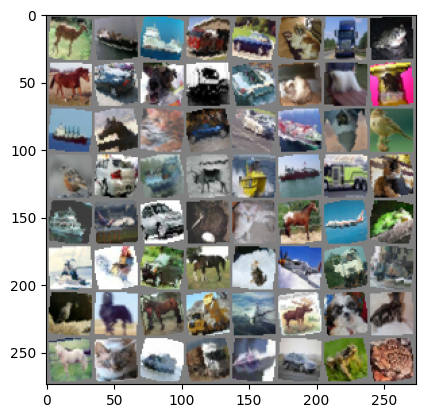

deer ship ship truckcar  dog  truckfrog horsecar  dog  truckcar  cat  dog  cat  ship horsecat  car  car  ship planebird bird car  ship deer ship ship truckcat  ship planecar  bird cat  horseplanefrog ship bird car  horsecat  planetrucktruckbird horsehorsetruckplanedeer dog  cat  horsecat  ship truckship car  frog frog 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img/ 2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

IMPORTING RESNET18

In [15]:
import torchvision.models as models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs =  model.fc.in_features
model.fc = nn.Linear(num_ftrs,10) #Modifying the Final Layer to 10 classes
model.train()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

DEFINING THE SGD OPTIMIZER

In [21]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

IMPLEMENTING EARLY STOPPING


In [6]:
class EarlyStopping:
  def __init__(self,patience=5):
    self.patience= patience
    self.best_acc = 0.0
    self.counter = 0
    self.stop_training = False

  def check_early_stop(self,val_acc):
    if val_acc > self.best_acc:
      self.best_acc = val_acc
      self.counter  = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        print(f'Early stopping triggered after {self.patience} epochs')
        self.stop_training = True

DEFINING THE TRAINING LOOP

In [22]:
def train_model_with_early_stopping(model, criterion, optimizer, num_epochs=30, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Initialize the early stopping object
    early_stopping = EarlyStopping(patience=patience)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / test_size
        val_acc = val_corrects.double() / test_size

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save best model weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        # Check early stopping
        early_stopping.check_early_stop(val_acc)
        if early_stopping.stop_training:
            print(f"Training stopped at epoch {epoch+1}")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return model

model = train_model_with_early_stopping(model,criterion,optimizer,num_epochs=30)

Epoch 1/30
----------
Train Loss: 1.4348 Acc: 0.4879
Val Loss: 1.1187 Acc: 0.5992
Epoch 2/30
----------
Train Loss: 1.0397 Acc: 0.6353
Val Loss: 0.9690 Acc: 0.6569
Epoch 3/30
----------
Train Loss: 0.9192 Acc: 0.6804
Val Loss: 0.8740 Acc: 0.6901
Epoch 4/30
----------
Train Loss: 0.8389 Acc: 0.7056
Val Loss: 0.8262 Acc: 0.7157
Epoch 5/30
----------
Train Loss: 0.7843 Acc: 0.7244
Val Loss: 0.8017 Acc: 0.7238
Epoch 6/30
----------
Train Loss: 0.7444 Acc: 0.7396
Val Loss: 0.7668 Acc: 0.7316
Epoch 7/30
----------
Train Loss: 0.7029 Acc: 0.7522
Val Loss: 0.7446 Acc: 0.7431
Epoch 8/30
----------
Train Loss: 0.6774 Acc: 0.7625
Val Loss: 0.7152 Acc: 0.7502
Epoch 9/30
----------
Train Loss: 0.6548 Acc: 0.7684
Val Loss: 0.7044 Acc: 0.7542
Epoch 10/30
----------
Train Loss: 0.6326 Acc: 0.7785
Val Loss: 0.6881 Acc: 0.7579
Epoch 11/30
----------
Train Loss: 0.6069 Acc: 0.7854
Val Loss: 0.6851 Acc: 0.7647
Epoch 12/30
----------
Train Loss: 0.5901 Acc: 0.7927
Val Loss: 0.6711 Acc: 0.7624
Epoch 13/30
-

In [23]:
model.eval()#Setting the model to evaluation
model.cpu()#Moving model to CPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
import copy
import torch
from torch.ao.quantization import get_default_qconfig_mapping
import torch.ao.quantization.quantize_fx as quantize_fx
import torchvision
import torchvision.transforms as transforms


device = torch.device('cpu')
model_to_quantize = copy.deepcopy(model)
model_to_quantize = model_to_quantize.cpu()
model_to_quantize.eval() #Setting model to evaluation
#Specifying how to quantize thr model with QConfigMapping
qconfig_mapping = get_default_qconfig_mapping('qnnpack')

# Preparing the Model for Post Training Static Quantization
model_prepared = quantize_fx.prepare_fx(
    model_to_quantize,
    qconfig_mapping,
    example_inputs=(torch.rand(1,3,32,32),)
)

calibration_transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2023,0.1994,0.2010))
])

batch_size = 128

calibration_dataset = torchvision.datasets.CIFAR10(
    root= './data',
    train=True,
    download=True,
    transform= calibration_transform
)

calibration_loader = torch.utils.data.DataLoader(
    calibration_dataset,
    batch_size=batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

# Calibrating the Model
def calibrate(model,calibration_loader):
  model.eval()
  with torch.no_grad():
    for inputs, labels in calibration_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      model(inputs)

calibrate(model_prepared, calibration_loader) # runninng the calibration on a sample dataset
# Converting the Model to a Quantized model
model_quantized = quantize_fx.convert_fx(model_prepared)

Files already downloaded and verified


In [30]:
print(model_quantized) # Printing Quantized model

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.011861559003591537, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.007230428978800774, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.017117025330662727, zero_point=144, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0064690206199884415, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02411814220249653, zero_point=149, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.006674342323094606, zero_point=0, 

PRINTING THE SIZE AND ACCURACY OF THE QUANTIZED MODEL

In [31]:
import os
import torch
torch.save(model.state_dict(),'model.pth')
torch.save(model_quantized.state_dict(), 'model_quantized.pth')
fp_size = os.path.getsize('model.pth')
quantized_size = os.path.getsize('model_quantized.pth')

print(f'Normal model size: {fp_size/1024**2:.2f} MB')
print(f'Quantized model size: {quantized_size/1024**2:.2f} MB')

Normal model size: 42.72 MB
Quantized model size: 10.70 MB


EVALUATING THE ACCURACY OF THE QUANTIZED MODEL

In [33]:
def evaluate(model_quantized, data_loader, device):
  model_quantized.eval()
  correct = 0
  total =0
  with torch.no_grad():
    for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_quantized(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

device = torch.device('cpu')
model_quantized.to(device)

quant_accuracy = evaluate(model_quantized, test_loader, device)
print(f'Quantized model accuracy: {quant_accuracy:.4f}')



Quantized model accuracy: 78.5300
